<a href="https://colab.research.google.com/github/pvdklei/modelsmakemodels/blob/master/sebas/Autoencoder_sebas_4conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import train
import utils

In [2]:
traintransform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testtransform = traintransform

batch_size = 32
num_workers = 2

trainset = datasets.CIFAR10("/data/cifar10/train", train=True, transform=traintransform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = datasets.CIFAR10("/data/cifar10/test", train=False, transform=testtransform, download=True)
testloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Extracting /data/cifar10/train/cifar-10-python.tar.gz to /data/cifar10/train


Extracting /data/cifar10/test/cifar-10-python.tar.gz to /data/cifar10/test


In [3]:
imiter = iter(trainloader)
images, _ = next(imiter)
image = images[0]
images.shape


torch.Size([32, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


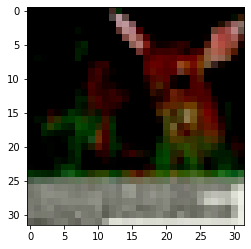

In [4]:
def showimage(image):
    image = image.detach().numpy()
    image = image.transpose((1, 2, 0))
    plt.imshow(image)
showimage(torchvision.utils.make_grid(images[0]))


In [30]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.2)

        self.conv1 = nn.Conv2d(3, 12, kernel_size=4, stride=2, padding = 1)
        self.conv2 = nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(48, 96, kernel_size=4, stride=2, padding=1)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return x
        
enc = Encoder()
enc(images).shape

torch.Size([32, 96, 2, 2])

In [31]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.drop = nn.Dropout(0.2)
        
        self.conv0 = nn.ConvTranspose2d(96, 48, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(48, 24, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(12, 3, kernel_size=4, stride=2, padding=1)
    
    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

decoder = Decoder()
decoder(enc(images)).shape

torch.Size([32, 3, 32, 32])

In [32]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoenc = AutoEncoder()
autoenc(images).shape

torch.Size([32, 3, 32, 32])

In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.drop = nn.Dropout(0.4)
        self.fc1 = nn.Linear(input_size, 
                             utils.intlerp(0.33, input_size, output_size))
        self.fc2 = nn.Linear(utils.intlerp(0.33, input_size, output_size), 
                          utils.intlerp(0.66, input_size, output_size))
        self.fc3 = nn.Linear(utils.intlerp(0.66, input_size, output_size), 
                          output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

mod = Classifier(10, 5)
mod(enc(images)).shape

torch.Size([32, 5])

In [33]:
model = AutoEncoder()
model

AutoEncoder(
  (encoder): Encoder(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout(p=0.2, inplace=False)
    (conv1): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Decoder(
    (drop): Dropout(p=0.2, inplace=False)
    (conv0): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [34]:
train.autotrain(model,
                optim.Adam(params=model.parameters(), lr=0.001),
                trainloader, testloader,
                nn.MSELoss(),
                epochs=20)

cuda
Epoch 0, Training loss: 291.38311548531055
Epoch 0, Validation loss: 257.4215393066406
Epoch 1, Training loss: 250.54863411188126
Epoch 1, Validation loss: 246.54808044433594
Epoch 2, Training loss: 244.78012240678072
Epoch 2, Validation loss: 243.05589294433594
Epoch 3, Training loss: 242.40404123067856
Epoch 3, Validation loss: 241.25918579101562
Epoch 4, Training loss: 240.10673013329506
Epoch 4, Validation loss: 238.65945434570312
Epoch 5, Training loss: 237.96208634972572
Epoch 5, Validation loss: 237.16940307617188
Epoch 6, Training loss: 236.55264784395695
Epoch 6, Validation loss: 235.79281616210938
Epoch 7, Training loss: 235.36485578864813
Epoch 7, Validation loss: 234.83570861816406
Epoch 8, Training loss: 234.43927817046642
Epoch 8, Validation loss: 234.0170135498047
Epoch 9, Training loss: 233.69357895851135
Epoch 9, Validation loss: 233.2510223388672
Epoch 10, Training loss: 233.13545130938292
Epoch 10, Validation loss: 232.91412353515625
Epoch 11, Training loss: 232

In [35]:
torch.save(model.state_dict(), 'checkpoint_4_convolutions.model')

In [36]:
state_dict = torch.load("checkpoint_4_convolutions.model")
model.load_state_dict(state_dict)

<All keys matched successfully>

torch.Size([32, 3, 32, 32])


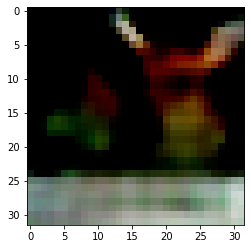

In [37]:
# after model
cpumodel = model.cpu()
out = cpumodel(images)
print(out.shape)
showimage(torchvision.utils.make_grid(out[0]))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


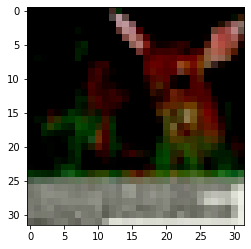

In [38]:
# original pic
showimage(torchvision.utils.make_grid(images[0]))
